The relation between the radiation fucntion $f(x,y,z)$ at a point P with a field distribution $F(\eta,\nu)$ over the aperture plane of the antenna is given by the equation: 

$$ \Large  f(x,y,z) = \int \frac{F(\xi,\eta)}{4\pi r} e^{-ikr} \left[ \left(ik+\frac{1}{r} \right) \hat{z}\cdot r_1 + ik\hat{z}\cdot\hat{s} \right] d\eta d\xi $$

Where the parameters of the equation are took from the following image:

<center>
<img src="pictures/antenna_holo.png" style="height: 300px; width:300px;">
</center>

## Common approximations
1. $\frac{1}{r}<<< k$
2. $\frac{1}{r} \sim \frac{1}{R}$  outside the bracket
3. The term $\hat{z}\cdot r_1$ can be replaced by $\hat{z}\cdot R = \cos(\theta)$
4. The term $\hat{z}\cdot \hat{s}$ represent the deviation from the uniform phase over the aperture. If the deviation is small the term can be considered to be 1.

With this assumptions the equations is:

$$\Large f(x,y,z) = \frac{i}{2\lambda R}\int F(\xi,\eta)[\cos(\theta)+1]e^{ikr}d\eta d\xi $$
 
 Where $r= \sqrt{(x-\xi)^2+(y-\eta)^2+z^2}$ 

## Far field approximation (Fraunhofer region)
In the far field, R tends to infinity, $R_1$ and $r_1$ are parallel then you could express $r=R-(u\xi+v\eta)$ and for a high gain antenna the interesting region is confined to small values of $\theta$ so it can use $\cos(\theta)=1$. Then the equation is transformed to:

$$\Large f(u,v) = \frac{i}{\lambda}\frac{e^{-ikR}}{R} \int F(\xi,\eta)e^{-ik(\xi u+\eta v)} d\xi d\eta$$


Which is a fourier trannsform in 2-D of the apperture. So given a certain aperture distribution we are able to calculate the far field using the fourier transform.

The oposite is also true, we are able to determine the illumination at the aperture if we measure the beam pattern. If we do that we will obtain a complex illumination $F(\xi,\eta) = A(\xi, \eta)e^{i\phi(\xi,\eta)}$ where the errors of the surface are related with the phase by the equation:

$$\Large \epsilon_n(\xi,\eta) = \frac{\lambda}{4\pi} \phi(\xi,\eta)\sqrt{1+\frac{\xi^2+\eta^2}{4F^2}} $$

Where $\epsilon_n$ is the error normal to the surface and $F$is the foci of the antena. If we disregrard the geometry then the error is given by the Ruze formula:
$$\large \phi = \frac{4\pi}{\lambda}\epsilon$$

## Zernike polynomials

Zermike polynomials are a sequence of orthogonal polynomials on the unitary disk.Thery are used to describe different types of aberrations on optics. One advantage of the zernike polynomials is that they can be normalized so the value of each component is proportional to the overall effect on the surface error. 

<center>
<img src="pictures/zermike_pols.png">
</center>



In [1]:
import numpy as np
import matplotlib.pyplot as plt


def circular_aperture(d,N, L):
    """
    d = diametre in meters of the aperture
    L = Lenght of the map (should be L>d)
    N = number of points
    """
    y,x = np.meshgrid(np.linspace(-L/2,L/2,N),
                        np.linspace(-L/2,L/2,N))
    r = np.sqrt(x**2+y**2)
    phi = np.arctan2(y,x)
    dx = L/N
    illumination = np.ones((N,N))
    illumination[r>d/2] = 0
    return illumination,x,y,r,phi, dx


def cassegrain_aperture(d1, d2, w_spider, N,L):
    """
    d1= diameter of the primary in m
    d2= diameter of the secondary in m
    w_spider: width of the spider that sustain the secondary
    L = size of the MAP
    N = number of points
    """
    illumination,x,y,r,phi,dx = circular_aperture(d1,N,L)
    illumination[r<d2/2] = 0
    illumination[np.abs(x)<w_spider] = 0
    illumination[np.abs(y)<w_spider] = 0
    return illumination,x,y,r,phi, dx


def add_zernike_phase(illumination,r,phi,d, aberration_amplitude,zernike, phase_weight=None):
    """
    Add zernike polynomials to the illumination to have an aberrated beam
    illumination = the currents at the aperture
    r= computed radius for the illumination map points (geometrical)
    phi = phase of the illumination maps points (geometrical)
    zernike = zernike modes from 3-9
    phase_weight = weight for each zernike mode, if None is random
    """
    if(phase_weight is None):
        phase_weight = np.random.randn(7)
    rho = r/(d/2)   ##standard coordinate to compute zernike pol
    #neglected piston and tilt
    zm2p2 = np.sqrt(6)*rho**2*np.sin(2*phi)  ## oblique astigmatism
    zp0p2 = np.sqrt(3)*(2*rho**2 -1)          ## defocus
    zp2p2 = np.sqrt(6)*(rho**2)*np.sin(2*phi)  ## vertical astigmatism
    zm3p3 = np.sqrt(8)*rho**3*np.sin(3*phi)   ## vertical trefiol
    zm1p3 = np.sqrt(8)*(3*rho**3 - 2*rho)*np.sin(phi) ## vertical coma
    zp1p3 = np.sqrt(8)*(3*rho**3 - 2*rho)*np.cos(phi) ## horizontal coma
    zp3p3 = np.sqrt(8)*rho**3*np.cos(3*phi)   ## oblique trefiol
    z = [zm2p2,zp0p2,zp2p2,zm3p3,zm1p3,zp1p3,zp3p3]
    phase = 0
    for i in range(len(z)):
        phase += phase_weight[i]*z[i]
    illumination = illumination*np.exp(1j*phase*aberration_amplitude)
    return illumination

def ruze_scattering(illumination, epsilon, phase=None):
    """
    ruze eq -> P = P_0*np.exp(4*np.pi*e/lambda)
    epsilon: expresed in lambdas
    """
    if(phase is None):
        phase = np.random.randn()
    illumination = illumination*np.exp(phase*1j*4*np.pi*epsilon)
    return illumination


def fraunhofer(A, wavelength, delta_x):
    """
    Add
    """
    u = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(A)))
    angular_width = np.rad2deg(wavelength/delta_x)  ##deg
    angular_width *= 60  #armin
    return angular_width, u

def calculate_power(u):
    ##psf: point spread function
    psf = np.abs(u)**2
    psf_norm = psf/np.max(psf)
    psf_norm += 1e-25    ##avoid zero in log
    psf_db = 10*np.log10(psf_norm)
    return psf, psf_db

def gaussian_illumination(mu_x,mu_y,sigma_x, sigma_y, L,N):
  ##check how ot overimpose this to the other apertures
  y,x = np.meshgrid(np.linspace(-L/2,L/2,N),
                        np.linspace(-L/2,L/2,N))
  illumination = np.exp(-((x-mu_x)**2/(2*sigma_x**2)+(y-mu_y)**2/(2*sigma_y)))
  illumination = 1/(2*np.pi*sigma_x*sigma_y)*illumination

  r = np.sqrt(x**2+y**2)
  phi = np.arctan2(y,x)
  dx = L/N
  return illumination,x,y,r,phi, dx


Text(0.5, 0.98, 'Farfield beam')

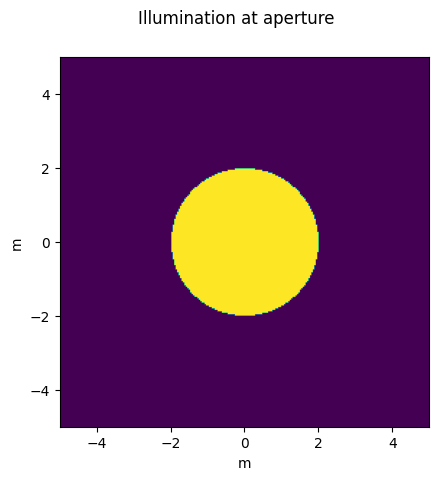

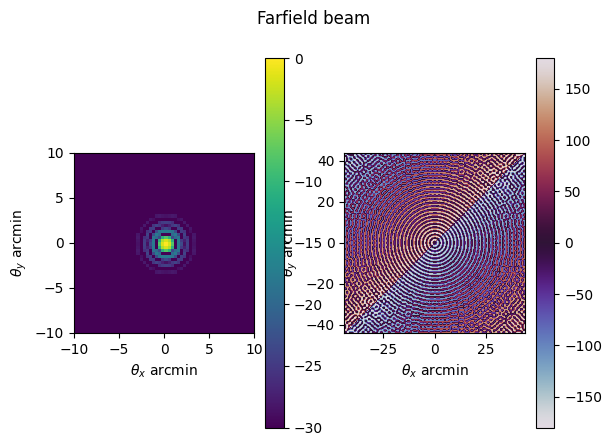

In [2]:
##circular aperture
d=4
L = 10
N = 256
wavelength = 0.001
aberration_amp = 0.4
zernike = np.random.randn(7)
phase_weight = None

##circular apperture
illumination,x,y,r,phi, dx  = circular_aperture(d,N,L)
fig, ax = plt.subplots(1)
ax.imshow(illumination, extent=[-L/2,L/2,-L/2,L/2])
ax.set_xlabel('m'); ax.set_ylabel('m')
fig.suptitle('Illumination at aperture')

#get the far field beam
angular_width, u = fraunhofer(illumination,wavelength, dx)
psf, psf_db = calculate_power(u)
fig, axes = plt.subplots(1,2)

img_pow = axes[0].imshow(psf_db, vmin=-30, vmax=0, extent=([-angular_width/2, angular_width/2,
                                                           -angular_width/2, angular_width/2
                                                           ]))
axes[0].set_xlim(-10,10)
axes[0].set_ylim(-10,10)
axes[0].set_xlabel('$\\theta_{x}$ arcmin')
axes[0].set_ylabel('$\\theta_{y}$ arcmin')
axes[1].set_xlabel('$\\theta_{x}$ arcmin')
axes[1].set_ylabel('$\\theta_{y}$ arcmin')

plt.colorbar(img_pow)
img_phase = axes[1].imshow(np.rad2deg(np.angle(u)), extent=([-angular_width/2, angular_width/2,
                                                           -angular_width/2, angular_width/2
                                                           ]), cmap='twilight')
plt.colorbar(img_phase)
fig.suptitle('Farfield beam')




Text(0.5, 0.98, 'Aberrated Farfield beam')

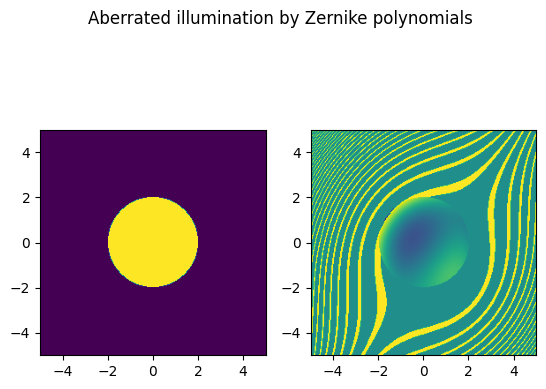

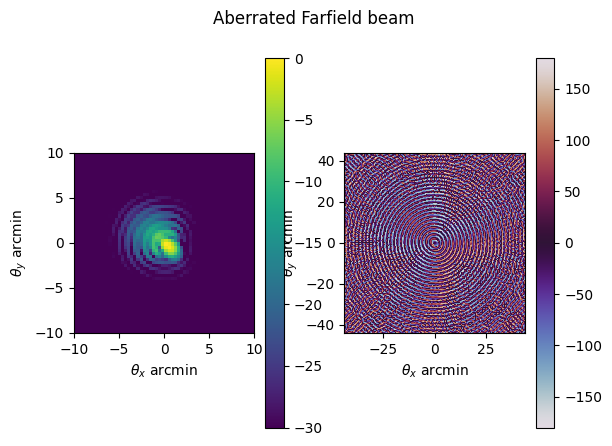

In [3]:
###add aberrations

aberrated_illumination = add_zernike_phase(illumination,r,phi,d, aberration_amp,zernike, phase_weight=phase_weight)
fig,axes = plt.subplots(1,2)
fig.suptitle('Aberrated illumination by Zernike polynomials')
axes[0].imshow(np.abs(aberrated_illumination), extent=[-L/2, L/2, -L/2, L/2])
axes[1].imshow(np.rad2deg(np.angle(aberrated_illumination)), extent=[-L/2, L/2, -L/2, L/2])

angular_width, u = fraunhofer(aberrated_illumination,wavelength, dx)
psf, psf_db = calculate_power(u)
fig, axes = plt.subplots(1,2)

img_pow = axes[0].imshow(psf_db, vmin=-30, vmax=0, extent=([-angular_width/2, angular_width/2,
                                                           -angular_width/2, angular_width/2
                                                           ]))
axes[0].set_xlim(-10,10)
axes[0].set_ylim(-10,10)
    axes[0].set_xlabel('$\\theta_{x}$ arcmin')
axes[0].set_ylabel('$\\theta_{y}$ arcmin')
axes[1].set_xlabel('$\\theta_{x}$ arcmin')
axes[1].set_ylabel('$\\theta_{y}$ arcmin')

plt.colorbar(img_pow)
img_phase = axes[1].imshow(np.rad2deg(np.angle(u)), extent=([-angular_width/2, angular_width/2,
                                                           -angular_width/2, angular_width/2
                                                           ]), cmap='twilight')
plt.colorbar(img_phase)
fig.suptitle('Aberrated Farfield beam')

Text(0.5, 0.98, 'Farfield beam')

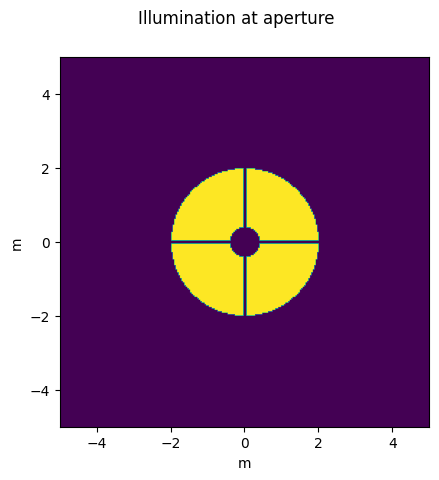

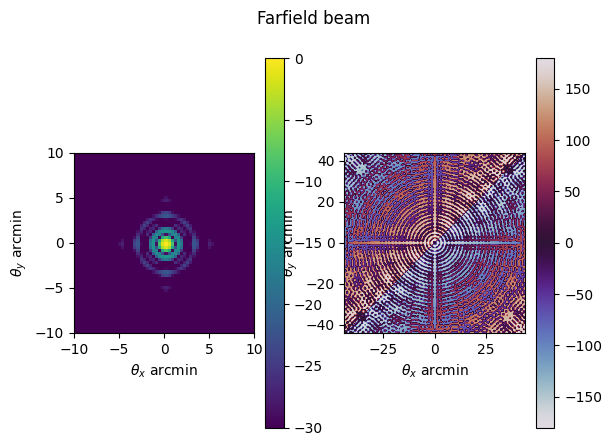

In [4]:
#standard cassegrain
d1=4
d2 =d1/5
spider_width = d1/200
L = 10
N = 256

wavelength = 0.001
aberration_amp = 0.4
zernike = np.random.randn(7)
phase_weight = None

illumination,x,y,r,phi, dx  = cassegrain_aperture(d1,d2,spider_width, N, L)
fig, ax = plt.subplots(1)
ax.imshow(illumination, extent=[-L/2,L/2,-L/2,L/2])
ax.set_xlabel('m'); ax.set_ylabel('m')
fig.suptitle('Illumination at aperture')

#get the far field beam
angular_width, u = fraunhofer(illumination,wavelength, dx)
psf, psf_db = calculate_power(u)
fig, axes = plt.subplots(1,2)

img_pow = axes[0].imshow(psf_db, vmin=-30, vmax=0, extent=([-angular_width/2, angular_width/2,
                                                           -angular_width/2, angular_width/2
                                                           ]))
axes[0].set_xlim(-10,10)
axes[0].set_ylim(-10,10)
axes[0].set_xlabel('$\\theta_{x}$ arcmin')
axes[0].set_ylabel('$\\theta_{y}$ arcmin')
axes[1].set_xlabel('$\\theta_{x}$ arcmin')
axes[1].set_ylabel('$\\theta_{y}$ arcmin')

plt.colorbar(img_pow)
img_phase = axes[1].imshow(np.rad2deg(np.angle(u)), extent=([-angular_width/2, angular_width/2,
                                                           -angular_width/2, angular_width/2
                                                           ]), cmap='twilight')
plt.colorbar(img_phase)
fig.suptitle('Farfield beam')

Text(0.5, 0.98, 'Aberrated Farfield beam')

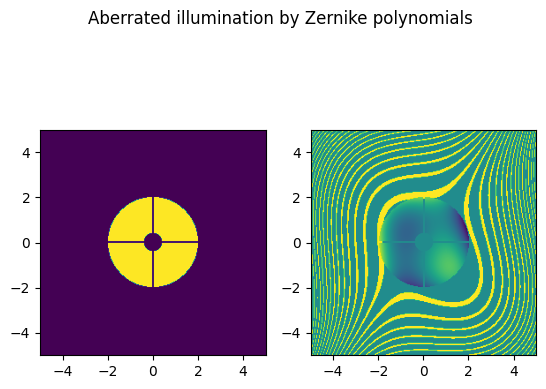

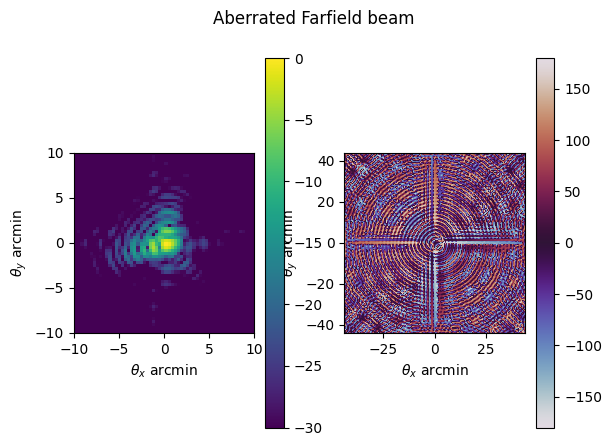

In [5]:
###add aberrations

aberrated_illumination = add_zernike_phase(illumination,r,phi,d, aberration_amp,zernike, phase_weight=phase_weight)
fig,axes = plt.subplots(1,2)
fig.suptitle('Aberrated illumination by Zernike polynomials')
axes[0].imshow(np.abs(aberrated_illumination), extent=[-L/2, L/2, -L/2, L/2])
axes[1].imshow(np.rad2deg(np.angle(aberrated_illumination)), extent=[-L/2, L/2, -L/2, L/2])

angular_width, u = fraunhofer(aberrated_illumination,wavelength, dx)
psf, psf_db = calculate_power(u)
fig, axes = plt.subplots(1,2)

img_pow = axes[0].imshow(psf_db, vmin=-30, vmax=0, extent=([-angular_width/2, angular_width/2,
                                                           -angular_width/2, angular_width/2
                                                           ]))
axes[0].set_xlim(-10,10)
axes[0].set_ylim(-10,10)
axes[0].set_xlabel('$\\theta_{x}$ arcmin')
axes[0].set_ylabel('$\\theta_{y}$ arcmin')
axes[1].set_xlabel('$\\theta_{x}$ arcmin')
axes[1].set_ylabel('$\\theta_{y}$ arcmin')

plt.colorbar(img_pow)
img_phase = axes[1].imshow(np.rad2deg(np.angle(u)), extent=([-angular_width/2, angular_width/2,
                                                           -angular_width/2, angular_width/2
                                                           ]), cmap='twilight')
plt.colorbar(img_phase)
fig.suptitle('Aberrated Farfield beam')

Text(0.5, 0.98, 'Aberrated Farfield beam')

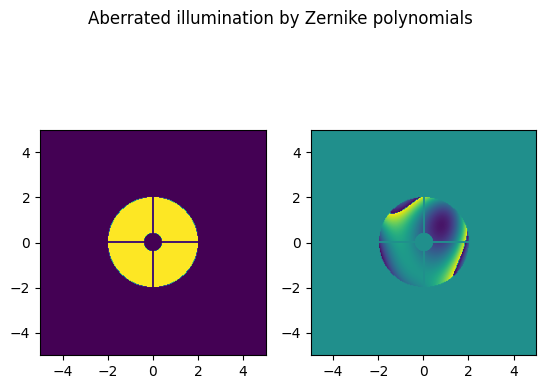

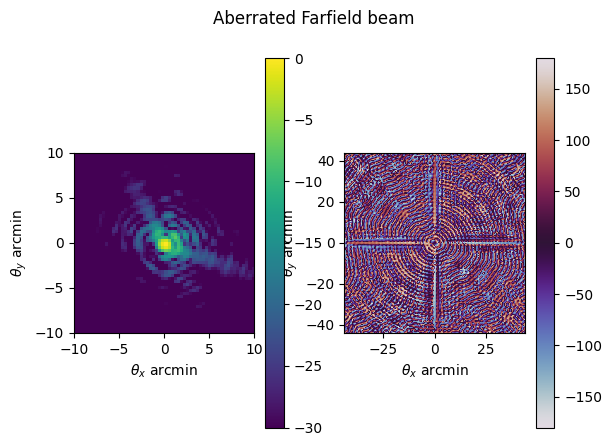

In [6]:
###substract the weird phase effect outside the apperture 

aberrated_illumination = add_zernike_phase(illumination,r,phi,d, aberration_amp,zernike, phase_weight=phase_weight)
aberrated_illumination = np.sqrt(aberrated_illumination**2) ##outside the aperture the phase varies between 0 and 180
fig,axes = plt.subplots(1,2)
fig.suptitle('Aberrated illumination by Zernike polynomials')
axes[0].imshow(np.abs(aberrated_illumination), extent=[-L/2, L/2, -L/2, L/2])
axes[1].imshow(np.rad2deg(np.angle(aberrated_illumination)), extent=[-L/2, L/2, -L/2, L/2])

angular_width, u = fraunhofer(aberrated_illumination,wavelength, dx)
psf, psf_db = calculate_power(u)
fig, axes = plt.subplots(1,2)

img_pow = axes[0].imshow(psf_db, vmin=-30, vmax=0, extent=([-angular_width/2, angular_width/2,
                                                           -angular_width/2, angular_width/2
                                                           ]))
axes[0].set_xlim(-10,10)
axes[0].set_ylim(-10,10)
axes[0].set_xlabel('$\\theta_{x}$ arcmin')
axes[0].set_ylabel('$\\theta_{y}$ arcmin')
axes[1].set_xlabel('$\\theta_{x}$ arcmin')
axes[1].set_ylabel('$\\theta_{y}$ arcmin')

plt.colorbar(img_pow)
img_phase = axes[1].imshow(np.rad2deg(np.angle(u)), extent=([-angular_width/2, angular_width/2,
                                                           -angular_width/2, angular_width/2]),
                           cmap='twilight')
plt.colorbar(img_phase)
fig.suptitle('Aberrated Farfield beam')

Text(0.5, 0.98, 'Aberrated Farfield beam')

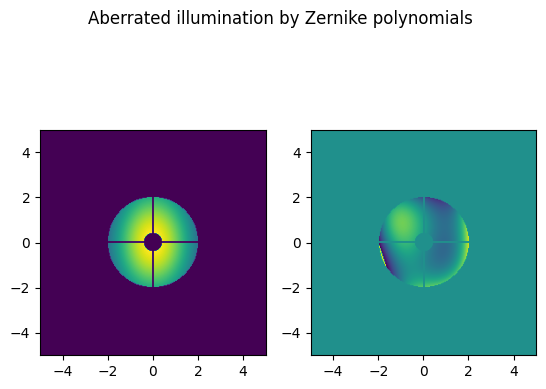

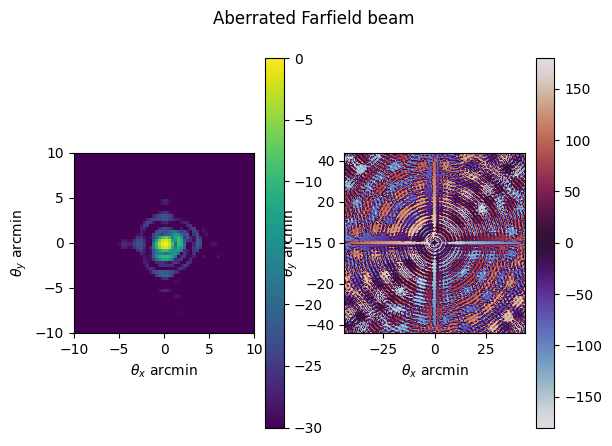

In [7]:
##gaussian illumination

illumination,x,y,r,phi,dx = gaussian_illumination(0,0,2,2,10,256)
#plt.imshow(illumination)

#limit the illumination to the aperture
#z,x,y,r,phi,dx = circular_aperture(d,N,L)
z,x,y,r,phi, dx  = cassegrain_aperture(d1,d2,spider_width, N, L)

illumination = illumination*z


aberrated_illumination = add_zernike_phase(illumination,r,phi,d, aberration_amp,zernike, phase_weight=phase_weight)
aberrated_illumination = np.sqrt(aberrated_illumination**2) ##outside the aperture the phase varies between 0 and 180
fig,axes = plt.subplots(1,2)
fig.suptitle('Aberrated illumination by Zernike polynomials')
axes[0].imshow(np.abs(aberrated_illumination), extent=[-L/2, L/2, -L/2, L/2])
axes[1].imshow(np.rad2deg(np.angle(aberrated_illumination)), extent=[-L/2, L/2, -L/2, L/2])

angular_width, u = fraunhofer(aberrated_illumination,wavelength, dx)
psf, psf_db = calculate_power(u)
fig, axes = plt.subplots(1,2)

img_pow = axes[0].imshow(psf_db, vmin=-30, vmax=0, extent=([-angular_width/2, angular_width/2,
                                                           -angular_width/2, angular_width/2
                                                           ]))
axes[0].set_xlim(-10,10)
axes[0].set_ylim(-10,10)
axes[0].set_xlabel('$\\theta_{x}$ arcmin')
axes[0].set_ylabel('$\\theta_{y}$ arcmin')
axes[1].set_xlabel('$\\theta_{x}$ arcmin')
axes[1].set_ylabel('$\\theta_{y}$ arcmin')

plt.colorbar(img_pow)
img_phase = axes[1].imshow(np.rad2deg(np.angle(u)), extent=([-angular_width/2, angular_width/2,
                                                           -angular_width/2, angular_width/2]),
                           cmap='twilight')
plt.colorbar(img_phase)
fig.suptitle('Aberrated Farfield beam')